#  MNIST 描述
MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels, and centered to reduce preprocessing and get started quicker. 

# 配置环境 torchvision
torchvision包是服务于pytorch深度学习框架的,用来生成图片,视频数据集,和一些流行的模型类和预训练模型.
* torchvision.datasets : Data loaders for popular vision datasets
* torchvision.models : Definitions for popular model architectures, such as AlexNet, VGG, and ResNet and pre-trained models.
* torchvision.transforms : Common image transformations such as random crop, rotations etc.
* torchvision.utils : Useful stuff such as saving tensor (3 x H x W) as image to disk, given a mini-batch creating a grid of images, etc.


In [2]:
import torch 
import torchvision
# 检测是否有cuda
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


* torch.cuda.is_available()
        # cuda是否可用；

* torch.cuda.device_count()
        # 返回gpu数量；

* torch.cuda.get_device_name(0)
        # 返回gpu名字，设备索引默认从0开始；

* torch.cuda.current_device()
        # 返回当前设备索引；

 

# 定义超参数 

In [3]:
n_epochs = 3   #完整数据集进行三次通过神经网络训练一次，并返回一次。
               #使用有限的数据集进行迭代，需要在神经网络中多次epochs，但随着epochs次数增加权重更新次数增加，model会从欠拟合-正常-过拟合发生转变。
batch_size_train = 64    #训练批量，单次使用训练集中一小批量（64个）样本对模型权重进行一次反向传播的参数更新
                         #训练集具有batch个数：60000/64=938次，每个epochs需要938次，每个epoch具有938个Iteration，权重更新次数：938次
                         #训练一个batch就是一个Iteration。
batch_size_test = 1000   #测试批量
                         #测试集具有batch个数为1
learning_rate = 0.01   #学习率
momentum = 0.5    #动量
log_interval = 10  #两次检查点之间操作系统数据块的个数。
                   #具体操作：训练批量64，log_interval=10，意味着每训练10个批量系统返回一次数据，也就是意味着640个数据返回输出一次。
                   #等价于：batch_size_train=32,log_interval=20.
random_seed = 1  #随机数生成种子，np中，相同seed数所生成的随机数相同。
torch.backends.cudnn.enabled = False  #cuDNN使用非确定性算法（nondeterministic algorithms ）
        #torch.backends.cudnn.enabled = True
        #torch.backends.cudnn.benchmark = True  
        #设置True，cuDNN中内置的auto-tuner将会让程序在开始时花费一点额外时间，为整个网络的每个卷积层搜索最适合它的卷积实现算法，进而实现网络的加速。
        
torch.manual_seed(random_seed) #为cpu设置种子用于生成随机数
            #torch.cuda.manual_seed(args.seed)  ，为GPU设置随机数种子
            #torch.cuda.manual_seed_all(args.seed)  ，为多个GPU设置随机数种子

# 加载数据集 

## DataLoaders
高效，简洁，直观的网络输入数据结构，便于使用和扩展。使用步骤：
* ① 创建一个 Dataset 对象
* ② 创建一个 DataLoader 对象
* ③ 循环这个 DataLoader 对象，将img, label加载到模型中进行训练
> pytorch中接口目的：将自定义的Dataset根据batch size大小、是否shuffle等封装成一个Batch Size大小的Tensor，用于后面的训练。
> 
先介绍一下DataLoader(object)的参数：

    * dataset(Dataset): 传入的数据集
    * batch_size(int, optional): 每个batch有多少个样本
    * shuffle(bool, optional): 在每个epoch开始的时候，对数据进行重新排序
    * sampler(Sampler, optional): 自定义从数据集中取样本的策略，如果指定这个参数，那么shuffle必须为False
    * batch_sampler(Sampler, optional): 与sampler类似，但是一次只返回一个batch的indices（索引），需要注意的是，一旦指定了这个参数，那么batch_size,shuffle,sampler,drop_last就不能再制定了（互斥——Mutually exclusive）
    * num_workers (int, optional): 这个参数决定了有几个进程来处理data loading。0意味着所有的数据都会被load进主进程。（默认为0）
    * collate_fn (callable, optional): 将一个list的sample组成一个mini-batch的函数
    * pin_memory (bool, optional)： 如果设置为True，那么data loader将会在返回它们之前，将tensors拷贝到CUDA中的固定内存（CUDA pinned memory）中.

    * drop_last (bool, optional): 如果设置为True：这个是对最后的未完成的batch来说的，比如你的batch_size设置为64，而一个epoch只有100个样本，那么训练的时候后面的36个就被扔掉了…
    如果为False（默认），那么会继续正常执行，只是最后的batch_size会小一点。

    * timeout(numeric, optional): 如果是正数，表明等待从worker进程中收集一个batch等待的时间，若超出设定的时间还没有收集到，那就不收集这个内容了。这个numeric应总是大于等于0。默认为0
    * worker_init_fn (callable, optional): 每个worker初始化函数 If not None, this will be called on each
    worker subprocess with the worker id (an int in [0, num_workers - 1]) as
    input, after seeding and before data loading. (default: None)

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True,       #‘./data/’为根目录，
                                                                         #‘train=true’表数据作用适用于训练，
                                                                         #‘download=true’表从线上下载数据集并放入根目录，不会重复下载
                             transform=torchvision.transforms.Compose([  ##transforms模块提供了一般的图像转换操作
                                                                         #.transforms.compose()将多个transforms组合起来                                              
                               torchvision.transforms.ToTensor(),  #归一化之前把PIL Image或者numpy.ndarray的（HxWxC）转成Tensor的（CxHxW）类型
                               torchvision.transforms.Normalize(   #数据归一化Normalize(mean,std)，给定通道均值和标准差，对图像每个通道值进行标准差归一化处理，input[channel] = (input[channel]-mean[channel])/std(channel)
                                 (0.1307,), (0.3081,))             #ToTensor返回的尺寸（C,H,W）的图片归一化，返回Tensor类型图片
                             ])),
  batch_size=batch_size_train, shuffle=True)  #‘batch_size’:自动将数据分割为batch，加载数据带入模型时划分的批量大小，此处等于设定的批量值。
                                              #‘shuffle=True’:每一个epoch输出的batch数据打乱顺序。
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

### 展示已加载的测试集数据

* 数据个数/长度 = 1个epoch = batch_size*batch_idx 
* batch_idx(iteration):代表要进行多少次batch_size的迭代，在深度学习训练中，需要print出一个个阶段的精度/loss，而这个参数就是用来作为pirnt精度/loss的index。

In [5]:
examples = enumerate(test_loader) #enumerate(数据集，[起始位置])，默认0序号开始，将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标
batch_idx, (example_data, example_targets) = next(examples)  #batch_idx等价于iteration

print(example_targets)   #example案例中图片对应的实际数字标签
print(example_data.shape)  #测试数据的张量形状:1000个一维(灰阶)28x28像素图片

tensor([4, 4, 2, 1, 8, 8, 2, 8, 3, 8, 5, 5, 5, 3, 0, 3, 6, 3, 0, 7, 0, 7, 2, 3,
        3, 4, 8, 2, 6, 1, 1, 2, 9, 5, 8, 2, 0, 3, 2, 3, 9, 9, 9, 3, 7, 9, 5, 7,
        2, 1, 6, 7, 2, 9, 3, 1, 3, 2, 0, 4, 8, 7, 5, 2, 4, 6, 5, 3, 9, 8, 9, 6,
        2, 8, 3, 9, 5, 9, 5, 0, 0, 4, 0, 2, 3, 0, 2, 8, 5, 8, 2, 2, 1, 3, 1, 5,
        1, 7, 2, 8, 8, 4, 2, 2, 9, 3, 1, 1, 4, 7, 2, 8, 7, 6, 2, 7, 6, 3, 6, 1,
        9, 0, 9, 7, 7, 9, 4, 0, 9, 4, 0, 2, 0, 7, 5, 9, 0, 4, 6, 7, 9, 4, 2, 4,
        0, 1, 2, 1, 4, 9, 3, 5, 3, 7, 8, 8, 3, 8, 5, 9, 1, 8, 3, 6, 8, 3, 3, 8,
        1, 6, 7, 4, 3, 3, 5, 6, 9, 6, 0, 2, 5, 1, 8, 0, 1, 4, 1, 1, 1, 7, 2, 7,
        1, 1, 0, 4, 7, 2, 4, 6, 1, 4, 3, 6, 2, 7, 5, 4, 1, 3, 3, 3, 4, 7, 8, 0,
        4, 3, 5, 8, 9, 4, 1, 9, 4, 7, 7, 1, 9, 6, 0, 4, 2, 9, 2, 1, 3, 6, 6, 0,
        2, 2, 0, 0, 2, 5, 8, 9, 7, 0, 0, 9, 2, 0, 9, 2, 6, 9, 9, 5, 4, 3, 2, 9,
        9, 4, 3, 5, 1, 3, 8, 5, 8, 4, 9, 5, 1, 4, 4, 6, 0, 7, 6, 8, 8, 8, 0, 9,
        8, 4, 5, 9, 4, 6, 3, 9, 9, 4, 5,

# 用matplotlib展示example实例部分图像 

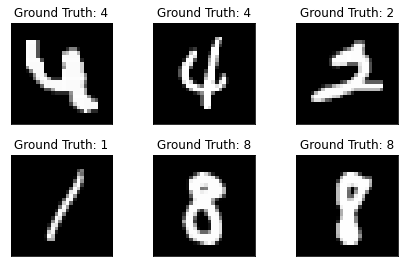

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)  #多个plt图，两行三列共六章图
  plt.tight_layout()  #调整各子图间的空白，试不重叠
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
                        #绘制数据集但不打印出来，第一项是图片数据来源，‘cmap=‘gray’’：图片颜色为黑白，默认是RGB，不执行插值（interpolation）
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()


# 构建网络
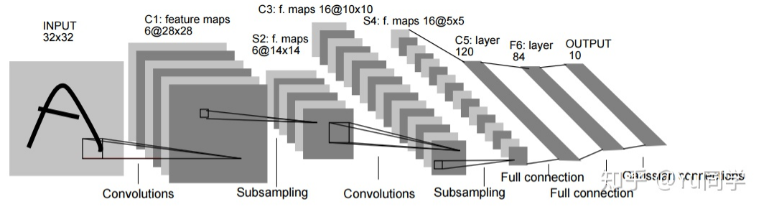

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Net(nn.Module):   #创建类别net，继承与nn中的module模块
    def __init__(self):
        super(Net, self).__init__()  #保留父类初始化方法，先运行nn.Module的初始化函数
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)   #第一层卷积函数,1通道（输入张量的通道数为1），输出10张量数，卷积核大小为5*5，10个1*5*5
                                                        #默认值：  stride=1，步长
                                                        #        padding=0，图像填充，上下左右填充，32x32 ---（padding=1）---34x34
                                                        #        dilation=1， 是否采用空洞卷积
                                                        #        groups=1，  是否采用分组卷积，需要被输入输出通道数整除，
                                                        #                   目前采用较多的是groups=in_channel
                                                        #                  eg input_size=[1,6,1,1]当groups=1时，即为默认的卷积层，则conv.weight.data.size为[6,6,1,1],实际上共有6 * 6=36个参数，
                                                        #                  若group=3时，则每组计算只有out_channel/groups = 2个channel参与，故每一组卷积层的参数大小为[6,2,1,1]，
                                                        #                   每一组共有6 * 2=12个参数，相当于每一组被重复用了3次（即group）次，最后再concat.
                                                        #        bias=True,  是否将bias添加为可学习参数。
                                                        #        padding_mode='zeros',  padding的模式，默认为0填充
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)  #第二层卷积函数，in_channel为10，out_channel为20，卷积核：20个10*5*5
        self.conv2_drop = nn.Dropout2d()     #丢弃层，dropout2d随机将整个2d特征图（张量）设置为0，每次反向传播被置0对象随机按概率产生，默认概率p=0.5，输入输出形状相同。
                                             #在前几层卷积层中，出现相邻像素强相关时，应使用dropout2d来增加特征图之间的独立程度。
        self.fc1 = nn.Linear(320, 50)     #全连接层fc1，输入320，输出50
        self.fc2 = nn.Linear(50, 10)    #全连接层fc2，输入50输出10

    def forward(self, x):   #前向计算
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  #对卷基层c1的输出进行最大池化操作，池化核大小为2*2，最后带入激活函数Relu进行输出。
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) #对卷基层c2进行丢弃操作后的输出进行最大池化操作，池化核2*2，带入激活函数Relu进行输出。
        x = x.view(-1, 320)  #将上次输出的所有Tensor展成1维Tensor，作为全连接层fc1的输入。
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)  #默认是training=True，作用是使dropout在训练时起作用。
        x = self.fc2(x)  #输出层
        return F.log_softmax(x)  #将输出最终引入（指数）softmax层



   > #def dropout(input, p=0.5, training=True, inplace=False):
   
   >if training == True:
        output = apply_dropout(input) # 对输入进行dropout        
   >elif training == False:
        output = input # 输出与输入保持一致

# 初始化网络和优化器 

## SGD: 
> optimizer=optim.SGD(network.parameters(),lr=learning_rate,momentum=momentum)

* SGD是最基础的优化方法，普通的训练方法, 需要重复不断的把整套数据放入神经网络NN中训练, 这样消耗的计算资源会很大.当我们使用SGD会把数据拆分后再分批不断放入 NN 中计算. 每次使用批数据, 虽然不能反映整体数据的情况, 不过却很大程度上加速了 NN 的训练过程, 而且也不会丢失太多准确率.
* Momentum:传统的参数 W 的更新是把原始的 W 累加上一个负的学习率(learning rate) 乘以校正值 (dx). 此方法比较曲折。我们把这个人从平地上放到了一个斜坡上, 只要他往下坡的方向走一点点, 由于向下的惯性, 他不自觉地就一直往下走, 走的弯路也变少了. 这就是 Momentum 参数更新。

In [9]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

network.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

# 训练模型 

### 记录loss下降过程 

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

* 训练之前执行一次测试循环，查看通过随机初始化的网络参数可达到的精度 

# NLL_LOSS  负对数似然损失函数
思想：
* 通过计算tensor的logsoftmax得到图片分类的概率分布，在确定target标签'[*,*,*]',则NLLLOSS则是取target对应的logsoftmax的tensors值进行__绝对值求和取平均__。
* Softmax计算出来的值范围在[0, 1]，值的含义表示对应类别的概率，也就是说，每行（代表每张图）中最接近于1的值对应的类别，就是该图片概率最大的类别，那么经过log求值取绝对值之后，就是最接近于0的值，如果此时每行中的最小值对应的类别值与Target中的类别值相同，那么每行中的最小值求和取平均就是最小，极端的情况就是0。总结一下就是，input的预测值与Target的值越接近，NLLLoss求出来的值就越接近于0，这不正是损失值的本意所在吗，所以NLLLoss可以用来求损失值。
*  input： https://img-blog.csdnimg.cn/20190714205213190.png
  
  softmax：https://img-blog.csdnimg.cn/20190714205641109.png

  nn.softmax:https://img-blog.csdnimg.cn/20190714210039289.png

  target的绝对值和求平均：https://img-blog.csdnimg.cn/20190714214751107.png

  NLLLOSS：https://img-blog.csdnimg.cn/20190714215111589.png

# CrossEntropyLoss()与NLLLOSS()区别
* NLLLOSS尽计算输入的对数概率与target各元素之间的绝对值求和取平均，不会有log_softmax的功能
* CrossEntropyLoss的计算结果与NLLLoss相同，区别是会自动求得对数概率，相当于softmax+log+NLLLoss。

In [11]:
def train(epoch):
  network.cuda().train()   #让model变成训练模式
  for batch_idx, (data, target) in enumerate(train_loader):
    data,target=data.to(device),target.to(device)
    optimizer.zero_grad()    #手动将梯度设置为0，
    output = network(data)  #前向计算，输出为数据输入网络后的结果
    loss = F.nll_loss(output, target)  #损失函数，预测输出和实际输出的差值
                                       #默认‘size_average=True’，计算每个batch各自的平均值，在求出所有batch平均值
    loss.backward()         #反向梯度计算
    optimizer.step()        #将反向计算结果传播回每个网络参数
    if batch_idx % log_interval == 0:  #log_interval:两次检查点之间操作系统数据块的个数。
                                       #已定义的超参数，每是个batch系统输出一次。
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),  #len(data.training).
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/home/cxking/桌面/code/MNIST1/model.pth')
      torch.save(optimizer.state_dict(), '/home/cxking/桌面/code/MNIST1/optimizer.pth')
    
#### 用model.state_dict() 加载存储文件时要确定目标文件父目录存在以及无同名文件夹
##下面是检查路径文件夹，没有的话创建路径
# import os
# if not os.path.exists('/home/cxking/桌面/code/MNIST1/model'):
#     os.makedirs('/home/cxking/桌面/code/MNIST1/model')
# if not os.path.exists('/home/cxking/桌面/code/MNIST1/optimizer'):
#     os.makedirs('/home/cxking/桌面/code/MNIST1/optimizer')

In [12]:
print(network.state_dict())
print(optimizer.state_dict())

OrderedDict([('conv1.weight', tensor([[[[ 0.0846, -0.1000,  0.1931, -0.0154,  0.0125],
          [-0.0486,  0.0819, -0.1187,  0.1192, -0.1065],
          [-0.1928, -0.0704,  0.1030,  0.1585, -0.1828],
          [ 0.1949, -0.1942,  0.1481, -0.0363, -0.1496],
          [-0.1576,  0.0892,  0.0474,  0.1033, -0.1868]]],


        [[[-0.0686,  0.1696,  0.1359,  0.0462, -0.1289],
          [-0.1605, -0.0967,  0.0878,  0.1985,  0.0211],
          [-0.0349,  0.0810, -0.1948,  0.1283, -0.1818],
          [-0.1366, -0.0841, -0.0219,  0.0868,  0.1900],
          [-0.1944,  0.0502, -0.1713,  0.0322,  0.1178]]],


        [[[ 0.0687, -0.1110, -0.0795,  0.0837,  0.0851],
          [-0.1371,  0.1539, -0.0893, -0.0142,  0.0988],
          [ 0.1621, -0.1606, -0.1591,  0.0981, -0.0100],
          [ 0.1123, -0.0493,  0.0691,  0.1437,  0.1520],
          [ 0.1038,  0.0124,  0.0931,  0.0051, -0.1536]]],


        [[[ 0.0580,  0.0310,  0.0436, -0.0597,  0.0763],
          [-0.1941, -0.1386, -0.1110, -0.1999,

In [13]:
def test():
  network.eval()   #model.eval()，pytorch会自动把BN和DropOut固定住，不会取平均，而是用训练好的值。
  test_loss = 0
  correct = 0
  with torch.no_grad():  #释放运算过的梯度，防止爆显存。
    for data, target in test_loader:
      data,target=data.to(device),target.to(device)
      output = network(data) 
      test_loss += F.nll_loss(output, target, size_average=False).item()  #size_average=false,意味着不进行平均值计算，只求和
      pred = output.data.max(1, keepdim=True)[1]    # 'dim=1':返回每一行中最大值的那个元素，且返回其索引（返回最大元素在这一行的列索引）
                                                    # keepdim=True:表示输出保持原来的维度
                                                    # '.max()[1]':只返回最大值的每个索引
      correct += pred.eq(target.data.view_as(pred)).sum()  #得出模型预测与测试集标签相等的总量
                    #torch.eq():比较两向量是否,两个向量的维度必须一致，如果相等，对应维度上的数为1，若果不相等则对应位置上的元素为0.
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [14]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/home/cxking/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/cxking/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3089, Accuracy: 674/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.355070
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.303719
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.339696
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.291877
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.292457
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.231430
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.231329
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.200502
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.172193
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.110738
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.009255
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.811025
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.838848
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.620533
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.466767
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.568215
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.361614
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.238762
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.311472
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.248183
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.331546
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.443538
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.369033
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.353078
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.432029
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.164510
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.304828
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.338622
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.183187
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.238630
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.320204
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.308084
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.190805
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.436563
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.381527
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.593143
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.154824
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.266499
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.230628


# 评估模型表现 

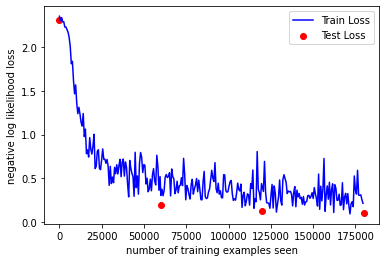

In [15]:
import matplotlib.pyplot as plt  #引入matplotlib软件的pyplot子模块进行绘图
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')  #确定训练集图像xy轴数据以及线段类型进行绘图。
plt.scatter(test_counter, test_losses, color='red') #确定测试集散点图
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')  #确定图示内容以及位置
plt.xlabel('number of training examples seen') #x轴标题
plt.ylabel('negative log likelihood loss') #y轴标题
plt.show()  #展示绘制图片

### 查看其他例子测试结果

In [16]:
with torch.no_grad():
  example_data=example_data.to(device)
  output = network(example_data)

/home/cxking/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


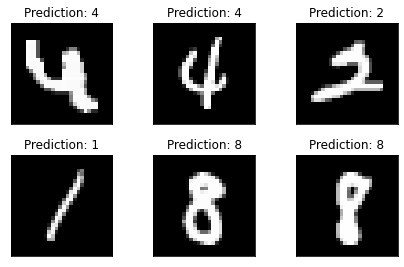

In [17]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0].cpu(), cmap='gray', interpolation='none')   #CUDA tensor格式的数据改成numpy时，需要先将其转换成cpu float-tensor随后再转到numpy格式。 numpy不能读取CUDA tensor需要将它转化为 CPU tensor
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()

# 通过检查点持续训练
* Checkpoints检查点

### 初始化网络和优化器 

In [19]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

###  用‘‘.load_state_dict()’’来加载上次训练保存的model文件

In [20]:
#torch.save(network.state_dict(), '/home/cxking/桌面/code/MNIST1/model.pth')
#torch.save(optimizer.state_dict(), '/home/cxking/桌面/code/MNIST1/optimizer.pth')

network_state_dict = torch.load( '/home/cxking/桌面/code/MNIST1/model.pth')
continued_network.load_state_dict(network_state_dict)
optimizer_state_dict = torch.load('/home/cxking/桌面/code/MNIST1/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

### 使用相同的列表来跟踪损耗值

In [21]:
for i in range(4,9):   #前面已经训练了3个epoch，接着之前更新的参数继续训练第4到8个epoch。
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/home/cxking/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.389336
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.238443
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.303276
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.442159
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.261551
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.418749
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.322987
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.397911
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.291888
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.284163
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.372870
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.213404
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.309369
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.165931
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.157774
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.165672
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.245889
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.273045
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.261501
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.184415
Train Epoch: 4 [12800/60000 (

Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.258629
Train Epoch: 5 [45440/60000 (76%)]	Loss: 0.420459
Train Epoch: 5 [46080/60000 (77%)]	Loss: 0.154950
Train Epoch: 5 [46720/60000 (78%)]	Loss: 0.245363
Train Epoch: 5 [47360/60000 (79%)]	Loss: 0.133287
Train Epoch: 5 [48000/60000 (80%)]	Loss: 0.092895
Train Epoch: 5 [48640/60000 (81%)]	Loss: 0.210579
Train Epoch: 5 [49280/60000 (82%)]	Loss: 0.146412
Train Epoch: 5 [49920/60000 (83%)]	Loss: 0.383814
Train Epoch: 5 [50560/60000 (84%)]	Loss: 0.205374
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.193591
Train Epoch: 5 [51840/60000 (86%)]	Loss: 0.186874
Train Epoch: 5 [52480/60000 (87%)]	Loss: 0.127454
Train Epoch: 5 [53120/60000 (88%)]	Loss: 0.337103
Train Epoch: 5 [53760/60000 (90%)]	Loss: 0.215667
Train Epoch: 5 [54400/60000 (91%)]	Loss: 0.250229
Train Epoch: 5 [55040/60000 (92%)]	Loss: 0.239127
Train Epoch: 5 [55680/60000 (93%)]	Loss: 0.239148
Train Epoch: 5 [56320/60000 (94%)]	Loss: 0.208616
Train Epoch: 5 [56960/60000 (95%)]	Loss: 0.266676


Train Epoch: 7 [28800/60000 (48%)]	Loss: 0.120525
Train Epoch: 7 [29440/60000 (49%)]	Loss: 0.186906
Train Epoch: 7 [30080/60000 (50%)]	Loss: 0.216043
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.279379
Train Epoch: 7 [31360/60000 (52%)]	Loss: 0.151772
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.317196
Train Epoch: 7 [32640/60000 (54%)]	Loss: 0.283275
Train Epoch: 7 [33280/60000 (55%)]	Loss: 0.263796
Train Epoch: 7 [33920/60000 (57%)]	Loss: 0.180424
Train Epoch: 7 [34560/60000 (58%)]	Loss: 0.148590
Train Epoch: 7 [35200/60000 (59%)]	Loss: 0.129740
Train Epoch: 7 [35840/60000 (60%)]	Loss: 0.055911
Train Epoch: 7 [36480/60000 (61%)]	Loss: 0.134080
Train Epoch: 7 [37120/60000 (62%)]	Loss: 0.299390
Train Epoch: 7 [37760/60000 (63%)]	Loss: 0.181358
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.170957
Train Epoch: 7 [39040/60000 (65%)]	Loss: 0.126157
Train Epoch: 7 [39680/60000 (66%)]	Loss: 0.331084
Train Epoch: 7 [40320/60000 (67%)]	Loss: 0.120177
Train Epoch: 7 [40960/60000 (68%)]	Loss: 0.196391


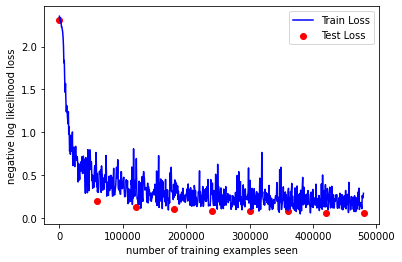

In [22]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()